## Laboratorio. Árboles y random forest para regresión y clasificación

## Librerías utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

* Se crean las constantes que serán utilizadas para el desarrollo del ejercicio. Por ejemplo, el valor de la semilla aleatoria y otras variables.
* Para mostar toda la lista de frecuencias max_mostrar_frecuencias = 0

In [2]:
semilla_aleatoria = 1234
cons_no_asignado="NoAsignado"
factor_datos_faltantes = 0.8
max_mostrar_frecuencias = 0

## 1.- Leer los datos del archivo housing_train.csv

In [3]:
df_base=pd.read_csv("housing_train.csv")
display(df_base.head(5))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2.- Tratamiento de missing. Si existen valores faltantes, decidir si eliminar los registros, llenarlos con valores como la media, la mediana o la moda y justifique su respuesta. 

Antes de realizar cualquier evaluación sobre los datos es importante siempre realizar un tratamiento previo a fin de abordar que hacer con la información faltante. Se citan algunos ejemplos: 
* Si la cantidad de datos faltantes es muy grande se recomienda borrar estas variables.
* Si existe una cantidad pequeña de filas con datos faltantes en sus variables se puede optar por borrarlas.
* Para variables categóricas se puede agregar un estado adicional que describa este factor.
* Se puede llenar los datos faltantes con la media, mediana o moda de esa variable tanto para variables numéricas o categóricas.
* Para variables categóricas, se puede optar por una asignación aleatoria de categorías escogido aquellas que se encuentren presentes en esa variable, tratado de buscar que se encuentren uniformemente distribuidas.


### Tratamiento missing variables numéricas.
* Se selecciona las variables de tipo numérico mediante un filtrado tipos de datos en el csv.

In [4]:
datos_numericos = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_var_numericas = df_base.select_dtypes(include=datos_numericos).copy()

### Se obtiene las columnas que tienen datos faltantes.

In [5]:
col_total_nulos = df_var_numericas.isnull().sum()
serie_col_nombres = col_total_nulos[col_total_nulos > 0]
display(serie_col_nombres)

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

### Se actualiza por la media de los datos.
* Debido a que la cantidad de datos es muy pequeña se optó por llenar los datos faltantes con la media para buscar su distribución uniforme.

In [6]:
for columna in serie_col_nombres.keys():
        mean_col=np.mean(df_var_numericas[columna])
        df_var_numericas[columna].replace(np.nan, mean_col, inplace=True)   
display('Verificación de datos faltantes : {0}'.format(df_var_numericas.isnull().sum().max()))

'Verificación de datos faltantes : 0'

### Tratamiento missing variables no numéricas.
* Se selecciona las variables de tipo no numérico mediante un filtrado tipos de datos en el csv.

In [7]:
df_var_no_numericas = df_base[df_base.columns.difference(df_var_numericas.columns)].copy()

### Se estima el factor de datos faltantes.

In [8]:
max_factor_moda = len(df_var_no_numericas)*factor_datos_faltantes
display('Máximo fator de datos faltantes : {0}'.format(max_factor_moda))

'Máximo fator de datos faltantes : 1168.0'

### Se obtiene las columnas que tienen datos faltantes.

In [9]:
total_no_numericas = df_var_no_numericas.isna().sum()
serie_col_nombres = total_no_numericas[total_no_numericas > 0]
display(serie_col_nombres)

Alley           1369
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
BsmtQual          37
Electrical         1
Fence           1179
FireplaceQu      690
GarageCond        81
GarageFinish      81
GarageQual        81
GarageType        81
MasVnrType         8
MiscFeature     1406
PoolQC          1453
dtype: int64

### Eliminar columnas que superan factor máximo datos faltantes.
* Debido a que existe una gran cantidad de datos faltantes se borra estas variables ya que no aportan ningún valor al modelo.

In [10]:
msk_max_fac_moda = total_no_numericas>max_factor_moda
df_cols_max_factor = total_no_numericas[msk_max_fac_moda]
df_var_no_numericas=df_var_no_numericas.drop(columns=df_cols_max_factor.keys(), axis=1)
total_no_numericas = df_var_no_numericas.isna().sum()
serie_col_nombres = total_no_numericas[total_no_numericas > 0]
display(serie_col_nombres)

BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
BsmtQual         37
Electrical        1
FireplaceQu     690
GarageCond       81
GarageFinish     81
GarageQual       81
GarageType       81
MasVnrType        8
dtype: int64

### Reemplazar datos categóricos por la moda.
* Debido a que las categorías tienen pocos datos faltantes y no se puede realizar el cálculo de la media se llena los datos faltantes con la moda.

In [11]:
df_cols_min_factor=total_no_numericas[~msk_max_fac_moda]
for columna in df_cols_min_factor.keys():
    val_mediana = df_var_no_numericas[columna].value_counts().idxmax()
    df_var_no_numericas[columna].replace(np.nan, val_mediana, inplace=True)
display('Verificacion actualizacion datos {0}'.format(df_var_no_numericas.isnull().sum().max()))

'Verificacion actualizacion datos 0'

### Para cada categoría se agrega un código que la identifica(variable ficticia).
* Las variables ficticias sirven para representar información cualitativa mediante el uso de estas variables. Estas sirven tantos para modelos de regresión (ficticias aditivas y multiplicativas) y también sirven para medir niveles por categorías.

In [12]:
encoder = preprocessing.LabelEncoder()
df_encoder=df_var_no_numericas.apply(encoder.fit_transform)
df_encoder=df_encoder.add_suffix("_c")
df_categorias_encoder=pd.concat([df_var_no_numericas,df_encoder],axis=1)

## 3. De las variables numéricas hallar el valor mínimo, el máximo, la mediana y la media.

* Para seleccionar los tipos de datos numéricos se escoge los tipos que los derriben en una lista, luego se utiliza el método describe(), en donde el percentil 50% equivale a la mediana de los datos.

In [13]:
display(df_var_numericas.describe())

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## 4. De las variables categóricas, listar las diferentes categorías y hallar la frecuencia de cada una de ellas. 

* Para el cálculo de frecuencia se las agrupa para cada variable por cada tipo.

In [14]:
k=0
for columna in df_var_no_numericas.columns:
    df_frec_cols=df_categorias_encoder[[columna,columna+"_c"]]
    df_frecuencia_cat=df_frec_cols.groupby([columna],as_index=False).size()           
    if k<max_mostrar_frecuencias:
        print(df_frecuencia_cat)
    if max_mostrar_frecuencias<=0:
        print(df_frecuencia_cat)
    k=k+1

BldgType
1Fam      1220
2fmCon      31
Duplex      52
Twnhs       43
TwnhsE     114
dtype: int64
BsmtCond
Fa      45
Gd      65
Po       2
TA    1348
dtype: int64
BsmtExposure
Av    221
Gd    134
Mn    114
No    991
dtype: int64
BsmtFinType1
ALQ    220
BLQ    148
GLQ    418
LwQ     74
Rec    133
Unf    467
dtype: int64
BsmtFinType2
ALQ      19
BLQ      33
GLQ      14
LwQ      46
Rec      54
Unf    1294
dtype: int64
BsmtQual
Ex    121
Fa     35
Gd    618
TA    686
dtype: int64
CentralAir
N      95
Y    1365
dtype: int64
Condition1
Artery      48
Feedr       81
Norm      1260
PosA         8
PosN        19
RRAe        11
RRAn        26
RRNe         2
RRNn         5
dtype: int64
Condition2
Artery       2
Feedr        6
Norm      1445
PosA         1
PosN         2
RRAe         1
RRAn         1
RRNn         2
dtype: int64
Electrical
FuseA      94
FuseF      27
FuseP       3
Mix         1
SBrkr    1335
dtype: int64
ExterCond
Ex       3
Fa      28
Gd     146
Po       1
TA    1282
dtype: int64


##	5. Hallar todas las correlaciones existentes entre las variables numéricas del conjunto de datos.
* Se utiliza la función de correlación de las variables, en donde un mejor modelo debe considerar aquellas variables más correladas con la variable a estimar y aquellas variables más decorrelladas entre sí. Aclarar que esto dependerá del método de aprendizaje que utilicemos.

In [15]:
display(df_var_numericas.corr())

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.009601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050199,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022895,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.009601,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179283,0.215828,...,0.077106,0.137454,0.009790,0.062335,0.037684,0.180868,0.001168,0.010158,0.006768,0.334901
LotArea,-0.033226,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103960,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410238,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127788,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.314745,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179186,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050199,0.022895,0.179283,0.103960,0.410238,-0.127788,0.314745,0.179186,1.000000,0.263582,...,0.159349,0.124965,-0.109849,0.018795,0.061453,0.011723,-0.029815,-0.005940,-0.008184,0.475241
BsmtFinSF1,-0.005024,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.263582,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


## 6. Determinar el conjunto de modelización y el de validación
* Para determinar el conjunto de modelización se realiza un merge entre el conjunto de variables numéricas y las variables no numéricas (para este caso se toma las variables ficticias). Adicionalmente se excluye la columna Id ya que no es útil para el modelo de estimación. Se separa las variables entre las columnas para realizar la predicción y la columna a predecir el precio de venta de un inmueble(SalePrice).

In [16]:
df_data = pd.concat([df_var_numericas,df_encoder],axis=1)
df_data.drop(['Id'], axis=1)
columnas_x=df_data.columns.difference(['SalePrice'])
X=df_data[columnas_x]
Y=df_data['SalePrice']

* Se segmenta los datos en dos conjuntos uno de entrenamiento con el 80% y de prueba 20% del total de datos respectivamente.

In [17]:
train_x,test_x,train_y,test_y=train_test_split(X,Y,test_size=0.2, random_state = semilla_aleatoria)

## 7. Pasos regresión método de Árboles 

### Parametrización del algoritmo de regresión.

In [18]:
reg_arboles = DecisionTreeRegressor(max_depth=15,
            max_features='auto', min_samples_leaf=1, min_samples_split=20,            
            random_state=semilla_aleatoria, splitter='best')
reg_arboles.fit(train_x,train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1234, splitter='best')

### Predicción del modelo.

In [19]:
predEY_reg_arb=reg_arboles.predict(test_x)

### Métricas.

In [20]:
print('MAE',mean_absolute_error(test_y,predEY_reg_arb))
print('MSE',mean_squared_error(test_y,predEY_reg_arb))
print('R2', r2_score(test_y,predEY_reg_arb))

MAE 24159.11219788087
MSE 1278008498.6537373
R2 0.7673217151580184


### Validación cruzada r2 score con mínimo 5 folds 
* En general el tratar de que una función aprenda sobre el mismo conjunto de datos sin que exista un conjunto de datos de test se considera como un error metodológico. Es decir que es óptimo para predecir los datos con los que se entrena, pero este generalmente falla al realizar predicciones sobre nuevos conjuntos de datos. Luego podemos utilizar un método de validación cruzada conocido como K-fold cross-validation en donde los datos se dividen en K subconjuntos. Cada subconjunto se utiliza como datos de prueba y el resto (K-1) como datos de entrenamiento.

In [21]:
def graficar_r2_scores(estimator, train_x, train_y,test_x,test_y,nparts=5,jobs=None):
    kfold = KFold(n_splits=nparts,shuffle=True, random_state=semilla_aleatoria)
    fig,axes = plt.subplots(figsize=(7, 3))
    axes.set_title("R2/Nro. Fold")
    axes.set_xlabel("Nro. Fold")
    axes.set_ylabel("R2")    
    train_scores = cross_val_score(estimator, train_x, train_y, cv = kfold, n_jobs=jobs,scoring="r2")
    test_scores = cross_val_score(estimator, test_x, test_y, cv = kfold, n_jobs=jobs,scoring="r2")        
    train_sizes = range(1,nparts+1,1)    
    axes.grid()    
    axes.plot(train_sizes, train_scores, 'o-', color="r",label="Datos Entrenamiento")
    axes.plot(train_sizes, test_scores, 'o-', color="g",label="Validacion Cruzada")
    axes.legend(loc="best")
    return train_scores

array([0.84414426, 0.760588  , 0.79611255, 0.74869211, 0.78572832])

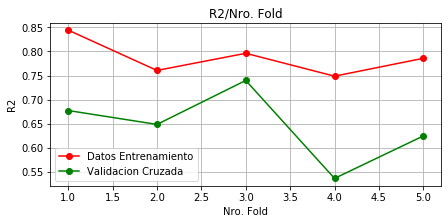

In [22]:
graficar_r2_scores(reg_arboles,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

## 8. Pasos regresión método Random Forest

### Parametrización del algoritmo de regresión.

In [23]:
reg_rndforest = RandomForestRegressor(n_estimators=100)
reg_rndforest.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Predicción del modelo.

In [24]:
predEY_reg_rfor=reg_rndforest.predict(test_x)

### Métricas.

In [25]:
print('MAE',mean_absolute_error(test_y,predEY_reg_rfor))
print('MSE',mean_squared_error(test_y,predEY_reg_rfor))
print('R2', r2_score(test_y,predEY_reg_rfor))

MAE 17339.990308219178
MSE 721568375.0944811
R2 0.8686289707071123


### Validación cruzada r2 score con mínimo 5 folds.

array([0.9149403 , 0.8535804 , 0.81369685, 0.87506906, 0.83981154])

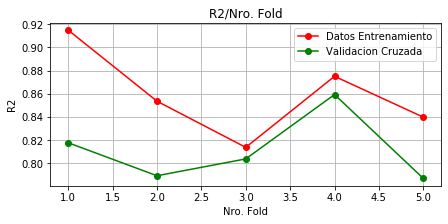

In [26]:
graficar_r2_scores(reg_rndforest,train_x,train_y,test_x,test_y,nparts=5,jobs=2)

## 9. Para los métodos de clasificación se crea los siguientes grupos: grupo1 SalePrice menor o igual a 100 000, grupo2 SalePrice entre 101 000 y 500 000 y grupo3 SalePrice mayor o igual a 501 000. 

* Se muestra el agrupamiento de datos para cada tipo.

In [27]:
df_sp=df_data[['SalePrice']].copy()
df_sp['SalePrice_grupo'] = cons_no_asignado
df_sp['SalePrice_grupo'] = np.where((df_sp['SalePrice'] <=100000),
                                    'grupo1',df_sp['SalePrice_grupo'])
df_sp['SalePrice_grupo'] = np.where((df_sp['SalePrice'] >100000)&(df_sp['SalePrice'] <=500000),
                                    'grupo2',df_sp['SalePrice_grupo'])
df_sp['SalePrice_grupo'] = np.where((df_sp['SalePrice'] >501000),
                                    'grupo3',df_sp['SalePrice_grupo'])
display(df_sp['SalePrice_grupo'].value_counts())

grupo2    1328
grupo1     123
grupo3       9
Name: SalePrice_grupo, dtype: int64

## 10. Determinar el conjunto de modelización y el de validación 
* Para determinar el conjunto de modelización se realiza un merge entre el conjunto de variables numéricas y las variables agrupadas por categorías. Adicionalmente se excluye la columna Id ya que no es útil para el modelo de estimación. Se separa las variables entre las columnas para realizar la predicción y la columna a predecir el clasificador por el grupo al que pertenece la venta de un inmueble.

In [28]:
df_data = pd.concat([df_var_numericas,df_encoder],axis=1)
df_data.drop(['Id'], axis=1)
columnas_x=df_data.columns.difference(['SalePrice'])
Xc=df_data[columnas_x]
Yc=df_sp['SalePrice_grupo']

In [29]:
train_xc,test_xc,train_yc,test_yc=train_test_split(Xc,Yc,test_size=0.2, random_state = semilla_aleatoria)

## 11. Pasos método Clasificación método de Árboles

### Parametrización del algoritmo de clasificación.

In [30]:
clas_arboles = DecisionTreeClassifier(max_depth=15,
            max_features='auto',  min_samples_leaf=1,
            random_state=semilla_aleatoria, splitter='best')
clas_arboles.fit(train_xc,train_yc)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

### Predicción del modelo.

In [31]:
predEY_clas_arb=clas_arboles.predict(test_xc)

### Métricas.

In [32]:
display(confusion_matrix(test_yc,predEY_clas_arb))
clas_report=classification_report(test_yc,predEY_clas_arb)
print(clas_report)

array([[ 17,  12],
       [ 19, 244]], dtype=int64)

              precision    recall  f1-score   support

      grupo1       0.47      0.59      0.52        29
      grupo2       0.95      0.93      0.94       263

    accuracy                           0.89       292
   macro avg       0.71      0.76      0.73       292
weighted avg       0.91      0.89      0.90       292



### Validación cruzada accuracy score con mínimo 5 folds.

In [33]:
def graficar_accuracy_scores(estimator, train_x, train_y,test_x,test_y,nparts=5,jobs=None):
    kfold = KFold(n_splits=nparts,shuffle=True, random_state=semilla_aleatoria)
    fig,axes = plt.subplots(figsize=(7, 3))
    axes.set_title("Ratio de éxito(Accuracy)/Nro. Fold")
    axes.set_xlabel("Nro. Fold")
    axes.set_ylabel("Accuracy")    
    train_scores = cross_val_score(estimator, train_x,train_y, cv = kfold, n_jobs=jobs, scoring="accuracy")
    test_scores = cross_val_score(estimator, test_x, test_y, cv = kfold, n_jobs=jobs, scoring="accuracy")        
    train_sizes = range(1,nparts+1,1)    
    axes.grid()    
    axes.plot(train_sizes, train_scores, 'o-', color="r",label="Datos Entrenamiento")
    axes.plot(train_sizes, test_scores, 'o-', color="g",label="Validacion Cruzada")
    axes.legend(loc="best")
    return train_scores

array([0.91025641, 0.9017094 , 0.94017094, 0.87982833, 0.90128755])

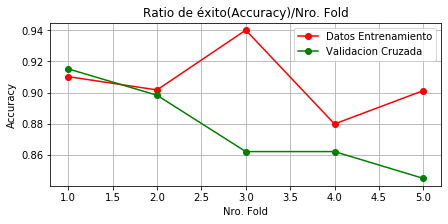

In [34]:
graficar_accuracy_scores(clas_arboles,train_xc,train_yc,test_xc,test_yc,nparts=5,jobs=2)

## 12. Pasos método Clasificación Random Forest

### Parametrización del algoritmo de clasificicación.

In [35]:
clas_rndforest = RandomForestClassifier(n_estimators=100,n_jobs=2, random_state=semilla_aleatoria)
clas_rndforest.fit(train_xc,train_yc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

### Predicción del modelo.

In [36]:
predEY_clas_rnd=clas_rndforest.predict(test_xc)

### Métricas.

In [37]:
display(confusion_matrix(test_yc,predEY_clas_rnd))
class_report=classification_report(test_yc,predEY_clas_rnd)
print(class_report)

array([[ 15,  14],
       [  3, 260]], dtype=int64)

              precision    recall  f1-score   support

      grupo1       0.83      0.52      0.64        29
      grupo2       0.95      0.99      0.97       263

    accuracy                           0.94       292
   macro avg       0.89      0.75      0.80       292
weighted avg       0.94      0.94      0.94       292

